In [2]:
#We use this to merge the validations to the data

In [3]:
import pandas as pd
import geopandas as gpd
from openlocationcode import openlocationcode as olc
import re
import numpy as np
import folium

In [4]:
#importing all three df
df_all = pd.read_csv('data/2025-09-30 Chris data/data/micropantries_all.csv', )
df_val = pd.read_csv('data/2025-09-30 Chris data/data/survey_validate_mp.csv')
df_add = pd.read_csv('data/2025-09-30 Chris data/data/survey_add_mp.csv')

In [5]:
df_all.columns

Index(['ID', 'NAME', 'LAT', 'LON', 'ADDRESS', 'CITY', 'ZIP', 'COUNTY',
       'PUGET_SOUND', 'STATE', 'POPULATION', 'LOCATION', 'NETWORK', 'DETAIL',
       'CONTACT', 'ADDITIONAL_LOCATION_INFO', 'IMAGE_LINK'],
      dtype='object')

In [6]:
m = folium.Map(location=[47.5, -122.5], zoom_start=10)
df_all_gpd = gpd.GeoDataFrame(
    df_all,
    # Use points_from_xy to generate the geometry objects (Shapely Points)
    # from the existing LAT and LON columns.
    geometry=gpd.points_from_xy(df_all['LON'], df_all['LAT']),
    # You may also want to set a Coordinate Reference System (CRS), like WGS84
    crs="EPSG:4326"
)

folium.GeoJson(df_all_gpd, popup= folium.GeoJsonPopup(
    fields = ['ID']
)).add_to(m)
m

In [7]:
df_val.columns

Index(['Timestamp', 'Add the micropantry ID you see on the map:',
       'Does the micropantry you see on the map still exists?',
       'What is the closest address to the micropantry?',
       'If you have google Maps on your phone, add the geo-coordinate of the micropantry using the following instructions.',
       'What type of micropantry is it?',
       'Describe the location of the micropantry:',
       'Is there overhead protection (eg. a roof)?', 'Is the micropantry:',
       'Describe the (approximate) size of the micropantry storage space in inches',
       'Number of shelves:', 'Is there a tight fitting door?',
       'Briefly describe what’s inside:', 'Please add a photo',
       'Any other observations?'],
      dtype='object')

In [8]:
df_val.columns = ['Timestamp', 'ID', 'exists', 'ADDRESS', 'lat_lon', 'type', 'location_desc',
                  'overhead', '??', 'size', 'shelves', 'door', 'contents', 'photo', 'observation']

In [9]:
df_add.columns

Index(['Timestamp', 'What is the closest address to the new micropantry?',
       'If you have google Maps on your phone, add the geo-coordinate of the micropantry using the following instructions.',
       'What type of micropantry is it?',
       'Describe the location of the micropantry:',
       'Is there overhead protection (eg. a roof)?', 'Is the micropantry:',
       'Describe the (approximate) size of the micropantry storage space',
       'Number of shelves:', 'Is there a tight fitting door?',
       'Briefly describe what’s inside:', 'Please add a photo',
       'Any other observations?'],
      dtype='object')

In [10]:
df_add.columns = ['Timestamp', 'ADDRESS', 'lat_lon', 'type', 'location_desc',
                  'overhead', '??', 'size', 'shelves', 'door', 'contents', 'photo', 'observation']
df_add['ID'] = range(9000, 9000 + len(df_add))
df_add['exists'] = 'Yes, it still exists.'


In [11]:
merge_new = pd.concat([df_val, df_add], ignore_index=True)

# Transforming all the Plus Codes to lat, lon

In [12]:
plus_codes_df = merge_new[merge_new['lat_lon'].astype(str).str.contains('\\+')]

In [13]:
decoded_data = []

REF_LAT = 47.6062  # Seattle Latitude
REF_LON = -122.3321  # Seattle Longitude

for idx, code in plus_codes_df.iterrows():
    # 1. Clean up the code if it includes a name/location (e.g., "MJQG+R8R Seattle, Washington")
    # This keeps only the Plus Code part before the first space.
    plus_code_only = code['lat_lon'].split(' ')[0]

    try:
        # 2. Decode the Plus Code
        full_code = olc.recoverNearest(plus_code_only, REF_LAT, REF_LON)

        code_area = olc.decode(full_code)

        # 3. Extract the latitude and longitude of the center point
        lat = code_area.latitudeCenter
        lon = code_area.longitudeCenter

        # 4. Store the results
        decoded_data.append([f'{lat}, {lon}'])

    except Exception as e:
        # Handle any codes that might be malformed
        print(f"Could not decode {code['ID']}: {e}")

In [14]:
plus_codes_df.loc[:, 'lat_lon'] = decoded_data

In [15]:
#Adding them back to merge_new
merge_new.update(plus_codes_df)

In [16]:
import re
import pandas as pd

def parse_coordinates(coord_str):
    """
    Parses various coordinate string formats into a standard (lat, lon) tuple.
    Handles N/S/E/W notation, parentheses, commas, and the ' X ' separator.
    """
    # 1. Handle Missing Values
    if pd.isna(coord_str) or coord_str in (None, ''):
        return None

    s = str(coord_str).strip()

    # --- 1. Handle Lat/Lon with N/S/E/W suffixes and flexible separators ---
    # This regex is made extremely flexible in the separator group:
    # (Num) (Optional Dir/Deg) (Flexible Separator: spaces, X, comma, degrees) (Num) (Optional Dir/Deg)
    match_dir = re.match(
        # Group 1: Num | Group 2: Dir/Deg (e.g., N, ° N)
        r"(\d+\.?\d*)\s*([NSEW°]*)\s*[,X\s]*\s*(\d+\.?\d*)\s*([NSEW°]*)",
        s, re.IGNORECASE
    )

    if match_dir:
        # Extract matches: num1, dir1, num2, dir2
        n1, d1, n2, d2 = match_dir.groups()

        # Strip all non-directional characters (like '°') from directions
        d1 = d1.strip('°').upper()
        d2 = d2.strip('°').upper()

        try:
            val1, val2 = float(n1), float(n2)
        except ValueError:
            # Should not happen if regex is correct, but safe guard
            return None

        lat, lon, lat_dir, lon_dir = None, None, None, None

        # Determine which value is Latitude and which is Longitude based on direction
        # Prioritize N/S for Lat and E/W for Lon
        if d1 in ('N', 'S') and d2 in ('W', 'E'):
            lat, lon = val1, val2
            lat_dir, lon_dir = d1, d2
        elif d2 in ('N', 'S') and d1 in ('W', 'E'):
            lat, lon = val2, val1
            lat_dir, lon_dir = d2, d1

        # NOTE: If directions are missing (e.g., '47.7 122.3'), this block is skipped,
        # and the code falls through to Block 2, which expects signed coordinates.

        if lat is not None:
            # Apply standard WGS84 sign convention (S/W are negative)
            if lat_dir == 'S':
                lat *= -1
            if lon_dir == 'W':
                lon *= -1

            return lat, lon

    # --- 2. Handle Standard Signed Lat, Lon (e.g., 47.68961250000001, -122.374234375) ---
    # This also catches the formats like: "(47.5986658, -122.3109579)"

    # Removes parentheses/whitespaces and splits by comma.
    s_clean = s.strip('() ')
    parts = s_clean.split(',')

    if len(parts) == 2:
        try:
            latitude = float(parts[0].strip())
            longitude = float(parts[1].strip())
            return latitude, longitude
        except ValueError:
            pass # Failed to convert, fall through

    # --- 3. If all else fails, return None ---
    return None


# --- 1. Apply the function and store results in a temporary column ---
# This creates a Series where each element is either a (lat, lon) tuple or None.
merge_new['Parsed_Coords'] = merge_new['lat_lon'].apply(parse_coordinates)

# --- 2. Separate the results into Latitude and Longitude columns ---
# We use .apply(pd.Series) to efficiently split the tuples into two new columns.
# Rows containing None will result in NaN (the desired behavior for missing data).
coords_df = merge_new['Parsed_Coords'].apply(pd.Series)

# --- 3. Rename and merge the new columns ---
merge_new['LAT'] = coords_df[0]
merge_new['LON'] = coords_df[1]

# --- Optional: Clean up the temporary column
merge_new = merge_new.drop(columns=['Parsed_Coords'])

In [17]:
#Checking all the ids and seeing if they are close to the IDs they report
merge_new = gpd.GeoDataFrame(
    merge_new.drop(columns=['LAT', 'LON']),  # Optionally drop original columns
    geometry=gpd.points_from_xy(merge_new['LON'], merge_new['LAT']),
    crs='EPSG:4326'
)

In [18]:
df_all = gpd.GeoDataFrame(
    df_all.drop(columns=['LAT', 'LON'], errors='ignore'),  # Optionally drop original columns
    geometry=gpd.points_from_xy(df_all['LON'], df_all['LAT']),
    crs='EPSG:4326'
)

In [19]:
#passing it to a new CRS to make it comparable
merge_new = merge_new.to_crs('EPSG:32148')
df_all = df_all.to_crs('EPSG:32148')

In [20]:
merge_new_with_latlon = merge_new.dropna(subset='lat_lon')

In [21]:
#Seeing if the ones with no comparable ID have one pantry nearby to their location
existing_ids = df_all['ID'].values

for index, row in merge_new_with_latlon.iterrows():
    min_distance = float('inf')
    index_distance = 'All is away'
    if row['ID'] not in existing_ids:
        for indexx, row2 in df_all.iterrows():
            target_point = row2['geometry']
            if row['geometry'].distance(target_point) < min_distance:
                min_distance = row['geometry'].distance(target_point)
                index_distance = row2['ID']

        print(f'The {row['ID']} pantry is closest to {index_distance}, and that distance is {min_distance}')

#All these are new pantries

The 3180 pantry is closest to 14, and that distance is 545.8867219935894
The 3601 pantry is closest to 181, and that distance is 552.0979431793177
The 3180 pantry is closest to 14, and that distance is 545.8867219935894
The 0 pantry is closest to 139, and that distance is 568.0751340079247
The 9000 pantry is closest to 65, and that distance is 4644.175189083135
The 9001 pantry is closest to 65, and that distance is 4488.8870004808505
The 9002 pantry is closest to 176, and that distance is 531.4844875989106
The 9003 pantry is closest to 176, and that distance is 533.324770157656
The 9004 pantry is closest to 65, and that distance is 743.6284118053024
The 9005 pantry is closest to All is away, and that distance is inf
The 9006 pantry is closest to 247, and that distance is 337.95875515821916
The 9007 pantry is closest to 123, and that distance is 167.3220648280104


In [22]:
# Pre-extract the list of IDs from df_all once for efficiency
replacement = {}
deletion = {}

for index, row in merge_new.iterrows():
    current_id = row['ID']
    source_point = row['geometry']

    # 1. Check if the ID exists in the comparison dataset (df_all)
    if current_id in existing_ids:

        #Assigns the geometry of df_all that has the same ID
        matching_geometry_series = df_all.loc[df_all['ID'] == current_id, 'geometry']

        # Ensure we have a match before proceeding
        if not matching_geometry_series.empty:

            # Extract the single Point object from the Series
            matching_geometry = matching_geometry_series.iloc[0]

            # Initialize min_distance with the distance to the matching ID
            min_distance = source_point.distance(matching_geometry)
            index_distance = current_id  # The starting closest pantry is itself
        else:
            # If the ID is in existing_ids but doesn't exist in the geometry column (unlikely)
            min_distance = float('inf')
            index_distance = 'No Match Found'

        # 2. Iterate through ALL pantries in df_all to find the TRUE minimum distance
        for indexx, row2 in df_all.iterrows():
            target_point = row2['geometry']

            # Calculate distance to the current target pantry
            current_distance = source_point.distance(target_point)

            if current_distance < min_distance:
                min_distance = current_distance
                index_distance = row2['ID']

        if index_distance != row['ID'] and min_distance < 30:
            print(f"Replacement: The {current_id} pantry is closest to {index_distance}, and that distance is {min_distance}")
            replacement[current_id] = index_distance
        if index_distance != row['ID'] and min_distance > 30:
            print(f"Deletion: The {current_id} pantry is closest to {index_distance}, and that distance is {min_distance}")
            deletion[current_id] = index_distance

    # Optional: Add an 'else' block if you want to find the nearest for NON-matching IDs as well
    # else:
    #     # Logic for finding the nearest to an entirely new pantry ID
    #     pass

Replacement: The 188 pantry is closest to 200, and that distance is 27.294350294652983
Replacement: The 66 pantry is closest to 64, and that distance is 5.846317285361459
Deletion: The 234 pantry is closest to 247, and that distance is 48.97049986664004
Replacement: The 280 pantry is closest to 180, and that distance is 14.544664413726363
Deletion: The 150 pantry is closest to 155, and that distance is 423.74481003943015
Replacement: The 149 pantry is closest to 139, and that distance is 21.754303857565958


In [23]:
for keys in replacement:
    merge_new.loc[merge_new['ID'] == keys, 'ID'] = replacement[keys]

# Assuming deletion.keys() is an iterable (like a list or set) containing the ID values to delete.
ids_to_delete = deletion.keys()

# Create a boolean mask: True for rows to KEEP (IDs NOT in the set of IDs to delete)
rows_to_keep = ~merge_new['ID'].isin(ids_to_delete)

# Use the mask to select only the rows you want to keep
merge_new = merge_new[rows_to_keep]


# Merging

In [24]:
# Use suffixes to clearly label the resulting geometry columns
merged = pd.merge(
    df_all,
    merge_new,
    on='ID',
    how='outer',
    suffixes=('_new', '_all')
)

# Assuming 'merged' is a DataFrame/GeoDataFrame where 'geometry_new' and 'geometry_all'
# are GeoSeries or contain Shapely geometry objects.
# 1. Use fillna(): It substitutes values where the first Series is truly missing (NaN/None).
merged['geometry'] = merged['geometry_new'].fillna(merged['geometry_all'])
merged['ADDRESS'] = merged['ADDRESS_new'].fillna(merged['ADDRESS_all'])
# Drop the old, redundant geometry columns
merged = merged.drop(columns=['geometry_new', 'geometry_all', 'ADDRESS_new', 'ADDRESS_all'])

# Convert the result back to a GeoDataFrame
merged_gdf = gpd.GeoDataFrame(merged, geometry='geometry', crs=merge_new.crs)

In [25]:
# Ensure merged_gdf is in the correct CRS (EPSG:4326 is standard Lat/Lon)
merged_gdf = merged_gdf.to_crs('EPSG:4326')

# Use the .y accessor for Latitude and the .x accessor for Longitude
merged['LAT'] = merged_gdf.geometry.y
merged['LON'] = merged_gdf.geometry.x

merged = merged.drop(columns=['geometry'])

In [26]:
conditions = [
    # Condition 1: Exists
    merged['exists'].isin(['Yes, it still exists.', 'Yes, it exists']),
    # Condition 2: Does not exist
    merged['exists'] == 'No, it does not exist anymore, and there is no other micropantry in the same block'
]

# Define the corresponding values for the new column
choices = ['YES', 'NO']

# Apply the conditions; everything else falls to the default ('DONT KNOW')
merged['exists_short'] = np.select(
    conditions,
    choices,
    default='DONT KNOW'
)

In [47]:
#Making sure that only 1 ID is going
merged_unique = merged.drop_duplicates(subset=['ID'], keep='first')

In [58]:
merged_unique.to_csv('data/2025-09-30 Chris data/data/micropantries_oo.csv', index=False)

# Getting the data for the validation

In [64]:
still_to_validate = merged_unique[merged['exists_short'] == 'DONT KNOW']

C:\Users\olive\AppData\Local\Temp\ipykernel_11404\3566183030.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  still_to_validate = merged_unique[merged['exists_short'] == 'DONT KNOW']


In [61]:
still_to_validate

,ID,NAME,CITY,ZIP,COUNTY,PUGET_SOUND,STATE,POPULATION,LOCATION,NETWORK,...,size,shelves,door,contents,photo,observation,ADDRESS,LAT,LON,exists_short
1,1,Rolling Bay Presbyterian Church -Eagle Scout P...,Bainbridge Island,98110.0,Kitsap,Yes,Washington,Urban,Western,Little Free Pantry - Mini Pantry Movement,...,NaN,NaN,NaN,NaN,NaN,NaN,11042 Sunrise Drive NE,47.664671,-122.510231,DONT KNOW
2,2,William Renton Lodge No. 29,Bainbridge Island,98110.0,Kitsap,Yes,Washington,Urban,Western,Little Free Pantry - Mini Pantry Movement,...,NaN,NaN,NaN,NaN,NaN,NaN,1299 Grow Ave NE,47.635619,-122.525951,DONT KNOW
3,3,Granny Barb and Cha Cha's Community Kitchen,Bainbridge Island,98110.0,Kitsap,Yes,Washington,Urban,Western,Little Free Pantry - Mini Pantry Movement,...,NaN,NaN,NaN,NaN,NaN,NaN,631 Eagle Cliff Rd NE,47.633098,-122.513146,DONT KNOW
4,4,The Little Free Pantry,Bellevue,98008.0,King,Yes,Washington,Urban,Western,The Little Free Pantry network,...,NaN,NaN,NaN,NaN,NaN,NaN,15727 NE 4th St,47.612405,-122.129603,DONT KNOW
5,5,The Little Free Pantry,Bellingham,98229.0,Whatcom,Yes,Washington,Urban,Western,The Little Free Pantry network,...,NaN,NaN,NaN,NaN,NaN,NaN,1714 Alabama St,48.762977,-122.451051,DONT KNOW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,328,Wilkeson Community Garden Pantry,Wilkeson,98396.0,Pierce,Yes,Washington,Urban,Western,Little Free Pantry - Mini Pantry Movement,...,NaN,NaN,NaN,NaN,NaN,NaN,Railroad St,47.103251,-122.045199,DONT KNOW
335,331,The Little Free Pantry,Yakima,98908.0,Yakima,No,Washington,Rural,Eastern,The Little Free Pantry network,...,NaN,NaN,NaN,NaN,NaN,NaN,14 N 48th Ave,46.597073,-120.572537,DONT KNOW
336,332,Free Food Pantry / Blessing Box,Yelm,98597.0,Thurston,Yes,Washington,Urban,Western,The Little Free Pantry network,...,NaN,NaN,NaN,NaN,NaN,NaN,206 3rd St SE,46.939326,-122.605419,DONT KNOW
338,334,Rainier Valley,Seattle,98118.0,King,Yes,Washington,Urban,Western,Seattle Community Fridge,...,NaN,NaN,NaN,NaN,NaN,NaN,48th Ave S & S Thistle St,47.527911,-122.272826,DONT KNOW


In [60]:
buffer = gpd.read_file('data/Buffers.shp').to_crs(merged_gdf.crs)
points_in_any_circle = gpd.sjoin(
    still_to_validate,
    buffer,
    how='inner',
    predicate='within'  # Check if the point is within the buffer polygon
)

still_to_validate = points_in_any_circle.drop_duplicates(subset=still_to_validate.columns)

ValueError: 'left_df' should be GeoDataFrame, got <class 'pandas.core.frame.DataFrame'>

<Axes: >

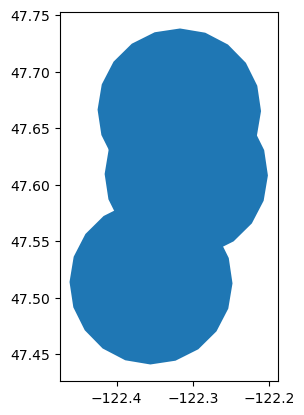

In [51]:
buffer.plot()

In [52]:
still_to_validate.shape[0] / 3

25.0

In [53]:
from sklearn.cluster import KMeans
import numpy as np

# --- 0. ASSUMPTION ---
# Assuming your GeoDataFrame is named 'merged_gdf' and is already in a projected CRS
# (e.g., EPSG:3857) where geometry coordinates are meaningful for clustering.

# Rename for clarity in the example
gdf = still_to_validate.copy()
gdf = gdf.to_crs('EPSG:32148')


# Use ceiling division to ensure all points are accounted for
K = 6

print(f"Calculated Number of Clusters (K): {K}")

# 2. Extract Coordinates
# KMeans operates on X and Y coordinates (Longitude and Latitude, respectively)
coords = np.array(list(zip(gdf.geometry.x, gdf.geometry.y)))

# 3. Perform K-Means Clustering
# We use K-Means as it's efficient for finding compact, roughly equal groups
kmeans = KMeans(
    n_clusters=K,
    n_init=10,
    random_state=42,
    # Use 'lloyd' for performance or 'full' if data is very large
    algorithm='lloyd'
)
gdf['cluster_id'] = kmeans.fit_predict(coords)

# 4. Analyze Cluster Sizes (Post-Clustering Check)
cluster_counts = gdf.groupby('cluster_id').size().sort_values(ascending=False)

print("\n--- Cluster Size Analysis ---")
print(cluster_counts)



Calculated Number of Clusters (K): 6

--- Cluster Size Analysis ---
cluster_id
0    32
3    16
1     9
5     8
4     6
2     4
dtype: int64


C:\Users\olive\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [54]:
import ipyleaflet as leaf
import json # <-- ADD THIS IMPORT

m = leaf.Map(center=(47.60, -122.30), zoom=12)
gdf = gdf.to_crs('EPSG:4326')
colors = {
    # Your existing colors
    '0': '#e6194B',  # Bright Red
    '1': '#3cb44b',  # Vibrant Green
    '2': '#4363d8',  # Strong Blue
    '3': '#ffe119',  # Bright Yellow
    '4': '#f58231',  # Orange
    '5': '#911eb4',  # Deep Purple
    '6': '#42d4f4',  # Light Cyan/Sky Blue
    '7': '#f032e6',  # Magenta/Fuchsia
    '8': '#bfef45',  # Lime Green
    '9': '#fabed4',  # Light Pink
    '10': '#469990', # Teal
    '11': '#dcbeff', # Lavender
    '12': '#9A6324', # Brown
    '13': '#800000', # Maroon
    '14': '#aaffc3', # Mint Green
}
for id in gdf['cluster_id'].unique():
    cluster = gdf[gdf['cluster_id'] == id]

    # 🌟 THE FIX: Convert GeoDataFrame to GeoJSON dict 🌟
    geojson_data = json.loads(cluster.to_json())

    geojson_layer = leaf.GeoJSON(
        data=geojson_data, # Use the converted dictionary
        style={
            'color': colors[str(id)],  # Line color
            'weight': 1,
            'fillColor': colors[str(id)], # Use color from dict instead of str(id)
            'fillOpacity': 0.7
        },
        point_style={
            'radius': 6,
            'fillColor': colors[str(id)], # Use color from dict instead of str(id)
            'color': '#fff',  # Marker border color
            'weight': 1,
            'fillOpacity': 0.8
        }
    )
    # Don't forget to add the layer to your map!
    m.add_layer(geojson_layer)

# Display the map (in a Jupyter environment)
m

Map(center=[47.6, -122.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

In [57]:
df

,ID,NAME,CITY,ZIP,COUNTY,PUGET_SOUND,STATE,POPULATION,LOCATION,NETWORK,...,size,shelves,door,contents,photo,observation,ADDRESS,LAT,LON,exists_short
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"21,28,17",1.0,No,"Bag of nuts, pack of ramen, bag of pasta, hamb...",https://drive.google.com/u/1/open?usp=forms_we...,There are 3 pantry boxes. None of them have do...,14300 linden Ave n,47.731813,-122.346438,YES
1,1,Rolling Bay Presbyterian Church -Eagle Scout P...,Bainbridge Island,98110.0,Kitsap,Yes,Washington,Urban,Western,Little Free Pantry - Mini Pantry Movement,...,NaN,NaN,NaN,NaN,NaN,NaN,11042 Sunrise Drive NE,47.664671,-122.510231,DONT KNOW
2,2,William Renton Lodge No. 29,Bainbridge Island,98110.0,Kitsap,Yes,Washington,Urban,Western,Little Free Pantry - Mini Pantry Movement,...,NaN,NaN,NaN,NaN,NaN,NaN,1299 Grow Ave NE,47.635619,-122.525951,DONT KNOW
3,3,Granny Barb and Cha Cha's Community Kitchen,Bainbridge Island,98110.0,Kitsap,Yes,Washington,Urban,Western,Little Free Pantry - Mini Pantry Movement,...,NaN,NaN,NaN,NaN,NaN,NaN,631 Eagle Cliff Rd NE,47.633098,-122.513146,DONT KNOW
4,4,The Little Free Pantry,Bellevue,98008.0,King,Yes,Washington,Urban,Western,The Little Free Pantry network,...,NaN,NaN,NaN,NaN,NaN,NaN,15727 NE 4th St,47.612405,-122.129603,DONT KNOW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,9003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"80 H, 105 W, 60 L",10.0,Yes,"boxes of fresh produce, oranges, blueberries, ...",https://drive.google.com/u/1/open?usp=forms_we...,"the pantry is next to a fridge, owner is Juli ...","5040 30th Ave S, Seattle, WA 98108",47.556009,-122.294090,YES
350,9004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"70""H, 48""W, 20""L",5.0,Yes,">50cans, multiple bags dri beans, plus...",https://drive.google.com/u/1/open?usp=forms_we...,"well known in the kirkland area, there's a sky...",10021 NE 124th St Kirkland WA,47.711080,-122.206570,YES
351,9005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"36, 48,36",1.0,No,Empty,https://drive.google.com/u/1/open?usp=forms_we...,There are three pantry boxes. All were empty b...,14300 Linden Ave N,NaN,NaN,YES
352,9006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"W 13, H 24 , L 12",2.0,Yes,Two boxes of tampons,https://drive.google.com/u/1/open?usp=forms_we...,NaN,7719 30th AVE SW,47.533088,-122.371456,YES


In [45]:
# df['geometry'] = gpd.GeoSeries.from_wkt(df['geometry'])